In [1]:
import tuplex

Welcome to

  _____            _
 |_   _|   _ _ __ | | _____  __
   | || | | | '_ \| |/ _ \ \/ /
   | || |_| | |_) | |  __/>  <
   |_| \__,_| .__/|_|\___/_/\_\ 0.3.1
            |_|
    
using Python 3.9.7 (default, Sep  3 2021, 12:45:31) 
[Clang 12.0.0 (clang-1200.0.32.29)] on darwin


TODO:
    
    Top-level setup.py should build/package Lambda as zip in pip package for easy upload.
    Script should autodetect location

In [2]:
from tuplex.distributed import setup_aws, default_scratch_dir

In [3]:
help(setup_aws)

Help on function setup_aws in module tuplex.distributed:

setup_aws(aws_access_key=None, aws_secret_key=None, overwrite=True, iam_user='leonhard', lambda_name='tuplex-lambda-runner', lambda_role='tuplex-lambda-role', lambda_file=None, region='us-east-1', s3_scratch_uri='tuplex-leonhard/scratch', quiet=False)



In [4]:
setup_aws(lambda_file='tplxlam.zip')

tplxlam.zip  43.9MiB / 43.9MiB  (100.00%)
Completed lambda setup in 21.39s


In [5]:
default_scratch_dir()

'tuplex-leonhard/scratch'

In [6]:
# There's currently a bug in the Lambda backend when transferring local data to S3: The full partition gets transferred, 
# not just what is needed.
c = tuplex.LambdaContext()

Tuplex WebUI can be accessed under http://localhost:5000


In [ ]:
%%time
c.parallelize([1, 2, 3, 4, 5]).map(lambda x: x * x).collect()

In [7]:
import time

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [18]:
from tqdm import tqdm

In [19]:
N_runs = 10

rows = []

for r in tqdm(range(N_runs)):
    start_time = time.time()
    res = c.parallelize([1, 2, 3, 4, 5]).map(lambda x: x * x).collect()
    duration = time.time() - start_time
    rows.append({'run' : r, 'duration':duration})
df = pd.DataFrame(rows)

100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


(0.0, 2.9364781379699707)

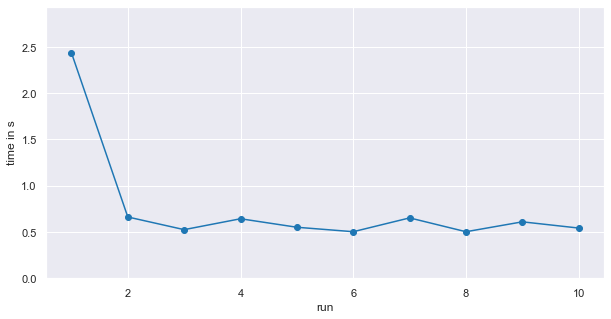

In [37]:
plt.figure(figsize=(10, 5))
sns.set_style('darkgrid')
# sns.set_context('poster')
sns.set_context('notebook')
plt.plot(df['run']+1, df['duration'], marker='o')
plt.xlabel('run')
plt.ylabel('time in s')
plt.ylim(0, df['duration'].max() + 0.5)

In [10]:
c.ls('s3://tuplex-public/*')

['s3://tuplex-public/test.csv', 's3://tuplex-public/tplxlam.zip']

In [13]:
c.ls('s3://tuplex-public')

[]

In [14]:
c.csv('s3://tuplex-public/test.csv').show(5)

Error: 
Exception:  AccessDenied
Error message:  Access Denied

In [15]:
%%file test.csv
A,B,C
1,2,3
4,5,6
7,8,9

Writing test.csv


In [17]:
# TODO: recursive as well!
c.cp('test.csv', default_scratch_dir() + '/test.csv')

RuntimeError: not yet supported

In [ ]:
c.options()

In [ ]:
import inspect

In [ ]:
%%time

f = lambda x: x

In [ ]:
res = inspect.getsourcefile(f)
print(res)

In [ ]:
f.__code__.co_filename

In [ ]:
f.__code__.co_firstlineno

In [ ]:
inspect.getfile(f), inspect.getclasstree(f)

In [ ]:
f.__dict__